# 14 Neural networks and deep learning

Part of ["Introduction to Data Science" course](https://github.com/kupav/data-sc-intro) by Pavel Kuptsov, [kupav@mail.ru](mailto:kupav@mail.ru)

Recommended reading for this section:

1. Grus, J. (2019). Data Science From Scratch: First Principles with Python (Vol. Second edition). Sebastopol, CA: O’Reilly Media

The following Python modules will be required. Make sure that you have them installed.
- `matplotlib`
- `requests`
- `numpy`
- `tensorflow`

## Lesson 1

### Neurons

An artificial neural network is machine learning model whose idea is based on the way the brain operates,

An artificial neural network as well as brain is a collection of neurons. 

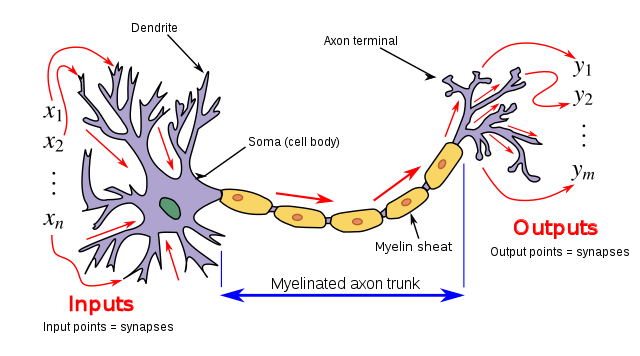

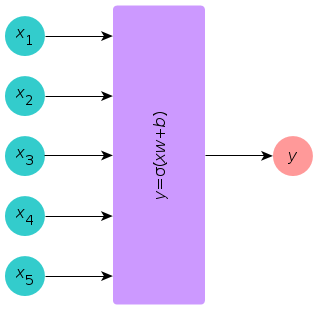

Each neuron collects signals from other neurons, sums them, each signal with its weight, then produces an output via nonlinear function $\sigma$.

$$
y=\sigma(xw+b)
$$

Here $w$ is a vector of weights of the input signals and $b$ is a bias. 

To find the output first we compute a scalar product of the vectors the input signals $x$ and its weights $w$:

$$
x w = (x_1, x_2, x_3, \dots) (w_1, w_2, w_3, \dots) = x_1 w_1 + x_2 w_2 + x_3 w_3 + \ldots
$$

The result is called weighted sum of the inputs. 

Then we add a scalar bias $b$ to it. This is needed to set the threshold of a neuron activation. 

Function $\sigma$ that is applied after adding the bias is called activation function.

In the most simple case the activation is a step function:

In [ ]:
def stepfunc(x):
    return 1.0 if x >= 0 else 0.0

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

xs = np.linspace(-3, 3, 100)
ys = [stepfunc(x) for x in xs]

fig, ax = plt.subplots()
ax.plot(xs, ys)
ax.set_xlabel(r"x")
ax.set_ylabel(r"y")
ax.grid()

This function is called "activation" because it is assumed that when the input is below the threshold neuron remains calm ($y=0$), and if the input passed the threshold the neuron is activated ($y=1$).

The threshold is given by a value $b$. If the weighted sum of the inputs $xw$ is smaller then $-b$ adding there $b$ gives a negative result so that the neuron remains calm:

$$
\text{if }(xw < -b) \text{ then } (xw + b < 0)
$$

And if the weighted sum is larger then $b$ the neuron is activated:

$$
\text{if }(xw > -b) \text{ then } (xw + b > 0)
$$

Varying $b$ we control the threshold of a neuron activation.

Although often other activation functions are used, the most of them have two parts: one represents a calm neuron and another the activated one.

Typically neural network contains a lot of coupled neurons. 

They are organized in layers: an input layer receives the input signals, its output is an input signals for the next layer and so on. The last layer produces the overall output of the whole network.

Neural networks can solve a wide variety of problems like handwriting recognition and face detection, text analysis and generation.

To make a network solve a problem the network has to be trained. The training includes tuning values of weights $w$ and biases $b$.

The result is a "black box". Inspecting the trained values of $w$ and $b$ does not give much understanding of how they are
solving a problem.

### Single neuron

In [ ]:
import csv
import numpy as np
import requests

def load_csv_dataset(file_name, dtype=float):
    """Downloads csv numeric dataset from repo to numpy array."""
    base_url = "https://raw.githubusercontent.com/kupav/data-sc-intro/main/data/"
    web_data = requests.get(base_url + file_name)
    assert web_data.status_code == 200
    
    reader = csv.reader(web_data.text.splitlines(), delimiter=',')
    data = []
    for row in reader:
        try:
            # Try to parse as a row of floats
            float_row = [dtype(x) for x in row]
            data.append(float_row)
        except ValueError:
            # If parsing as floats failed - this is header
            print(row)
            
    return np.array(data)

We consider the most simple example of the neural network including only one neuron. 

Let us now create it and inspect how it works.

For this purpose we will use a dataset `perceptron_data.csv`

In [ ]:
data = load_csv_dataset('perceptron_data.csv')
print(data.shape)

We observe that the dataset has 400 rows and two columns. 

Let us visualize it:

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(data[:, 0], data[:, 1]);
ax.axhline(y=5, color='k')
ax.axvline(x=0, color='k')
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.grid()

The points are clearly clustered into four groups. 

As a first step we are going to create a network that is able to identify a couple of two groups separated with the line $x_1=0$:

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(data[:, 0], data[:, 1]);
ax.axvline(x=0, color='k')
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.grid()

Our single neuron network must tell if a point is in the right half plane or in the left one.

Let us create a it 

In [ ]:
def theneuron(x, prm):
    """
    prm is a dictionary with two keys
    prm['w'] - vector of weights
    prm['b'] - scalar bias
    """
    x = np.array(x, dtype=float)
    w = np.array(prm['w'], dtype=float)
    b = prm['b']
    y = x @ w + b
    return 1 if y >= 0 else 0

To solve our simple problem we can easily find weights $w$ and bias $b$ manually without needing to apply the training. 

One can easily guess that $w=(1, 0)$ and $b=0$ are appropriate.

Let us check it. We predict the labels using suggested $w$ and $b$:

In [ ]:
prm0 = {'w': [1.0, 0.0], 'b': 0}

y_pred = [theneuron(x, prm0) for x in data]
print(y_pred)

In [ ]:
import matplotlib.pyplot as plt

colors = ['r', 'b']

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(data[:, 0], data[:, 1], color=[colors[y] for y in y_pred]);
ax.axvline(x=0, color='k')
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.grid()

We see that our neuron works perfectly well

A more complicated problem: let us find parameters of the neuron that is able to identify a top right group of points. 

In the other words, lets us split our dataset by a line like this:

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(data[:, 0], data[:, 1]);
ax.axline((-0.5, 6.5), (1.5, 4.5), color='k')
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.grid()

We need to find such $w_1$, $w_2$ and $b$ that $xw+b$ is zero along this line. 

In this case all points below it will be labeled by the neuron as belonging to the class 0 and those that are above will be of the class 1.

We have three unknown variables to find: $w_1$, $w_2$ and $b$. It means that we need three points along the separating line to write three equations for the unknown variables.

Inspecting the plot above we cab easily find these points:

$$
(x_1, x_2) = (-0.5, 6.5), (1.5, 4.5), (0.5, 5.5)
$$

Let us substitute them into the equation of the neuron $x_1 w_1 + x_2 w_2 + b = 0$:

$$
  \left\{
    \begin{aligned}
      {}& -0.5 w_1 + 6.5 w_2 + b = 0 \\
      {}& \phantom{+}1.5 w_1 + 4.5 w_2 + b = 0 \\
      {}& \phantom{+}0.5 w_1 + 5.5 w_2 + b = 0
    \end{aligned}
  \right.
$$

This equation set can be rewritten in a matrix form:

$$
\begin{pmatrix}
  -0.5 & 6.5 & 1 \\
  1.5  & 4.5 & 1 \\
  0.5  & 5.5 & 1
\end{pmatrix}
\begin{pmatrix}w_1 \\ w_2 \\ b\end{pmatrix} =
\begin{pmatrix}0 \\ 0 \\ 0\end{pmatrix}
$$

This equation can be treated as a matrix eigenvalue problem:

Given a matrix $M$ find such a vector $v$ that its multiplication by the matrix $M$ results in its stretching (or contracting) by $\lambda$:

$$
M v = \lambda v
$$

Here $\lambda$ is a scalar that have to be found. $\lambda$ is called eigenvalue and $v$ is an eigenvector of the matrix. 

In our case we have 

$$
M=
\begin{pmatrix}
  -0.5 & 6.5 & 1 \\
  1.5  & 4.5 & 1 \\
  0.5  & 5.5 & 1
\end{pmatrix}
$$

and we need a special eigenvalue $\lambda=0$. 

This is not guarantied of course that such the matrix has zero eigenvalue. In our case it means that we have took wrong points.

Computation of eigenvalues and eigenvectors is very easy with `numpy`. We just use function `np.linalg.eig`:

In [ ]:
M = np.array([[-0.5, 6.5, 1],[1.5, 4.5, 1],[0.5, 5.5, 1]])
lam, V = np.linalg.eig(M)
print("Eigenvalues of M are: ", lam)
print("Each column of V is an eigenvector of M:\n", V)

We see that one of the eigenvalues is very close to zero. This is what we need: exact zero can not be obtained due to numerical errors.

The corresponding eigenvector gives the required parameters of the neuron.

Notice that we can change signs of all elements of an eigenvector and it still will be the eigenvector.

We want to label the top right group as class 1 and the others as class 0. 

It happens if we change the signs of the coefficients.

In [ ]:
w1, w2, b = V[:, 2]
prm1 = {'w': [-w1, -w2], 'b': -b}
print(prm1)

Let us check how our neuron classify points of the dataset:

In [ ]:
y_pred = [theneuron(x, prm1) for x in data]
print(y_pred)

In [ ]:
import matplotlib.pyplot as plt

colors = ['r', 'b']

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(data[:, 0], data[:, 1], color=[colors[y] for y in y_pred]);
ax.axline((-0.5, 6.5), (1.5, 4.5), color='k')
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.grid()

Let us now find the neuron that is able to distinguish bottom left group of points

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(data[:, 0], data[:, 1]);
ax.axline((-1.5, 5.5), (0.5, 3.5), color='k')
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.grid()

Three points that we need for this are

$$
(x_1, x_2) = (-1.5, 5.5), (0.5, 3.5), (-0.5, 4.5)
$$

The equations for unknown coefficients read

$$
\begin{pmatrix}
  -1.5 & 5.5 & 1 \\
   0.5 & 3.5 & 1 \\
  -0.5 & 4.5 & 1
\end{pmatrix}
\begin{pmatrix}w_1 \\ w_2 \\ b\end{pmatrix} =
\begin{pmatrix}0 \\ 0 \\ 0\end{pmatrix}
$$

We are ready to compute eigenvalues of the matrix. The coefficients correspond to zero eigenvalue.

In [ ]:
M = np.array([[-1.5, 5.5, 1.0], [0.5, 3.5, 1.0], [-0.5, 4.5, 1.0]])
lam, V = np.linalg.eig(M)
print("Eigenvalues of M are: ", lam)
print("Each column of V is an eigenvector of M:\n", V)

In [ ]:
w1, w2, b = V[:, 1]
prm2 = {'w': [w1, w2], 'b': b}
print(prm2)

Let us check how our neuron classify points of the dataset:

In [ ]:
y_pred = [theneuron(x, prm2) for x in data]
print(y_pred)

In [ ]:
import matplotlib.pyplot as plt

colors = ['r', 'b']

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(data[:, 0], data[:, 1], color=[colors[y] for y in y_pred]);
ax.axline((-1.5, 5.5), (0.5, 3.5), color='k')
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.grid()

The single neuron is able to classify data if and only if they can be separated by a single straight line. Or if we have a multidimensional dataset - by a hyperplane.

The single neuron is unable to do its work if we have two groups like this:

In [ ]:
import matplotlib.pyplot as plt

colors = ['r', 'b']

y_manual = [1 if x[0]*(x[1]-5) > 0 else 0 for x in data]

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(data[:, 0], data[:, 1], color=[colors[y] for y in y_manual]);
ax.axline((-0.5, 6.5), (1.5, 4.5), color='k')
ax.axline((-1.5, 5.5), (0.5, 3.5), color='k')
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.grid()

This limitation of the single neuron is known as an "XOR problem" because it can be considered in terms of modeling logical functions. 

The single neuron can model logical AND, OR and NOT but can not model XOR, i.e., exclusive OR function.

However this and many much more complicated problems can be solved with neural networks that include more then one neuron and more then one layer.

In what follows we will consider networks of many neurons. 

It will be more convenient to define each neuron in a more compact form.

First we will create a class for a single neuron and later will define a class for a neuron layer.

In [ ]:
class Neuron:
    """
    Neuron with step activation
    """
    def __init__(self, w, b):
        self.w = np.array(w)
        self.b = b
    
    def __str__(self):
        """String reprsentation to print weights"""
        return f"w={self.w}, b={self.b}"
    
    def stepfunc(y):
        return 1 if y >= 0 else 0

    def __call__(self, x):
        y = np.array(x) @ self.w + self.b
        return Neuron.stepfunc(y)

Let us reconsider our neuron using a new class.

In [ ]:
pcp1 = Neuron(w=[0.16222142113076246, 0.16222142113076252], b=-0.9733285267845752)
print(pcp1)

We apply the new version of the neuron to the dataset like this

In [ ]:
y_pred = [pcp1(x) for x in data]
print(y_pred[:10])

In [ ]:
import matplotlib.pyplot as plt

colors = ['r', 'b']

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(data[:, 0], data[:, 1], color=[colors[y] for y in y_pred]);
ax.axline((-0.5, 6.5), (1.5, 4.5), color='k')
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.grid()

### Layer of neurons

Single neuron is not so interesting. Its possibilities are very limited.

It is much more interesting when multiple neurons are connected to a network.

The typical unit of neural network is a layer, a set of neurons that receive the same input signals and produce independent outputs.

Consider two neurons that are fed with the same input vector $x=(x_1, x_2, x_3)$. Assume for a moment that the activation is absent.

$$
y_1=(x_1, x_2, x_3) (w_{11}, w_{21}, w_{31}) + b_1 = x_1 w_{11} + x_2 w_{21} + x_3 w_{31} + b_1
$$

$$
y_2=(x_1, x_2, x_3) (w_{12}, w_{22}, w_{32}) + b_2 = x_1 w_{12} + x_2 w_{22} + x_3 w_{32} + b_2
$$

We need to remember here a vector-matrix multiplication. These two equations can be rewritten in a more compact way as follows:

$$
(y_1, y_2) =
(x_1, x_2, x_3)
\begin{pmatrix}
w_{11} & w_{12} \\
w_{21} & w_{22} \\
w_{31} & w_{32}
\end{pmatrix}
+ (b_1, b_2)
$$

Let us denote a matrix as $W$:

$$
W = 
\begin{pmatrix}
w_{11} & w_{12} \\
w_{21} & w_{22} \\
w_{31} & w_{32}
\end{pmatrix}
$$

And now $b$ is treated like a vector:

$$
b = (b_1, b_2)
$$

Neuron outputs can also be considered as a vector:

$$
y = (y_1, y_2)
$$

Now the operation of these two neurons can be represented as follows

$$
y = x W + b
$$

Let us finally recall the activation function. When we apply it to vectors an elementwise operation is assumed:

$$
y = \sigma(x W + b)
$$

We have derived this formula assuming that $x$ is three dimensional vector and there are two neurons. But this compact form can be written for arbitrary number of inputs and any neurons.

Thus the formula above represents a layer of neurons.

Below is the illustration of a layer of neurons. In this figure we see that all inputs are connected to all neurons. This is called dense layer. 

Full connections is not necessary. There are networks where each neuron is connected to a certain subset of the inputs.

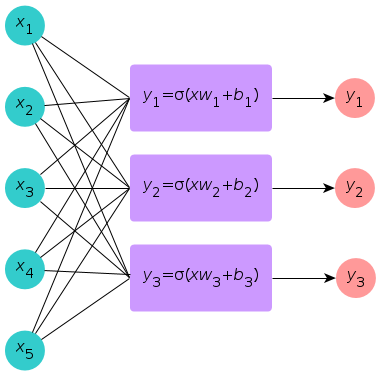

Let us define a class for a neuron layer. It is very much similar to the neuron class above.

Observe that we pass an activation function as a constructor parameter.

In [ ]:
class Layer:
    def __init__(self, W, b, activat):
        # Number of rows of W equals to the number of input signals
        # Number of columns of W and number of elements of b equals to neurons in the layer
        self.W = np.array(W)
        self.b = np.array(b)
        # W must be a rectangular matrix (W.shape can be like (3, 5))
        assert len(W.shape) == 2
        # b must be a vector (b.shape can be like (5,))
        assert len(b.shape) == 1
        # Number of columns of W must coincide with number of elements of b
        assert W.shape[1] == b.shape[0]
        self.activat = activat
    
    def __str__(self):
        """String reprsentation to print weights"""
        return f"W=\n{self.W}\nb=\n{self.b}"
    
    def __call__(self, x):
        y = np.array(x) @ self.W + self.b
        return self.activat(y)

We need to prepare the step function that can work with arrays. 

Numpy array can be compared with a constant like this

In [ ]:
tst = np.array([-1.2, 2.3])
tst >= 0

The result is an array of True and False. 

In Python (and in all other programming languages) boolean values False and True are actually represented by integers 0 and 1, respectively. 

Thus we will obtain the desired step function when convert the result of the comparison to integers:

In [ ]:
(tst >= 0).astype(int)

Thus the appropriate step function for numpy arrays reads:

In [ ]:
def stepfunc(y):
    return (y >= 0).astype(int)

### Two-layer feed-forward network

Let us create a network that resolves XOR problem.

First we create a layer of two neurons. 

One neuron will label points in the top right corner with 1 and the others with 0.

The other one will label bottom left corner as 1 and others as 0.

We just copy the coefficients from above. 

Observe that we write neuron weights as rows for convenience and then transpose them to form an appropriate matrix $W$.

In [ ]:
W1 = np.array([[0.16222142113076246, 0.16222142113076252], [-0.23570226039551573, -0.23570226039551598]]).T
b1 = np.array([-0.9733285267845752, 0.9428090415820632])
lay1 = Layer(W1, b1, stepfunc)
print(lay1)

Let us check how it works. First we apply the layer to the dataset and then convert sigmoid outputs to 0 or 1

In [ ]:
y_pred = lay1(data)
print(y_pred[:10])

To confirm that everything is alright we plot two scatter plots. The first is colorized according to the neuron 1 and the second - according to the neuron 2.

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

colors = ['r', 'b']

axs[0].scatter(data[:, 0], data[:, 1], color=[colors[y[0]] for y in y_pred])
axs[0].set_title("Labeled according to the neuron 1")
axs[1].scatter(data[:, 0], data[:, 1], color=[colors[y[1]] for y in y_pred])
axs[1].set_title("Labeled according to the neuron 2")

for ax in axs:
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.grid()

Let us see what combinations are reported by our layer. 

To obtain a list of unique values we usually convert a lits of data into a set. But now we have a lits of numpy arrays. Set can not be
created for it.

First we convert our data into a lits of tuples.

In [ ]:
y_pred_tuple = [tuple(y) for y in y_pred]
print(y_pred_tuple[:10])

Now we can see unique combinations:

In [ ]:
print(set(y_pred_tuple))

Combinations (1, 0) and (0, 1) indicate points at top right and bottom left corners, respectively. And (0, 0) corresponds to two other groups.

Let us remember that we want to create a network that distinguishes the top right and bottom left points as a one class and two others as the other class.

To do so we add another layer with a single neuron that receives outputs of the previous layer and sum them.

The sum is 1 for (1, 0) and (0, 1) and 0 for (0, 0).

This is it. We do not event need $b$ and the activation. Thus we set $b=0$ and pass to the layer constructor empty activation function.

In [ ]:
def identity(y):
    return y

In [ ]:
W2 = np.array([[1.0, 1.0]]).T
b2 = np.array([0])
lay2 = Layer(W2, b2, identity)
print(lay2)

To combine two layers we just send the output of the first one as an input for the second one:

In [ ]:
y_pred = lay2(lay1(data))
print(y_pred[:10])
print(y_pred.shape)

Now we are ready to show that our two layer network is able to distinguish the group of points as required.

Notice that the network output is two dimensional numpy array of floating point numbers. 

And we are going to use it as color indexes. 

For this purpose we need to take the first (and the only) element of each row and convert it to integer.

In [ ]:
colors = ['r', 'b']

y = y_pred[0]
print(y)

colors[int(y[0])]

In [ ]:
import matplotlib.pyplot as plt

colors = ['r', 'b']

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(data[:, 0], data[:, 1], color=[colors[int(y[0])] for y in y_pred]);
ax.axline((-0.5, 6.5), (1.5, 4.5), color='k')
ax.axline((-1.5, 5.5), (0.5, 3.5), color='k')
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.grid()

The network we created has the structure as follows

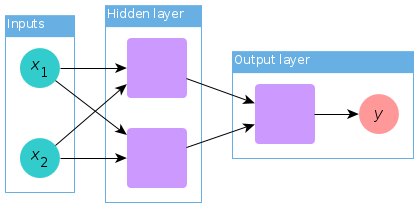

It has inputs and two layers. The layer in the middle is not visible by network users, since its result goes to another layer. 

This layer is called hidden. The last layer that produces the network prediction is called output layer.

In principle, this is a minimal structure of a network that can virtually do everything neural networks do.

There is a mathematical theorem, Universal approximation theorem, that states that this structure is enough for all purposes.

Of course for different problems we have to vary number of inputs and sizes of the layers. 

However in practice this is ineffective. In many cases a very large hidden layer is required and tuning its parameters becomes almost unsolvable problem. 

That is why instead of very wide networks with huge hidden layer, today deep networks are employed instead with many (actually vary many) layers that goes one after another.

Network where neurons collected in layers and each layer is connected to the next is called feed-forward network. 

### Sigmoid activation function

Step function as activation is inconvenient. 

Training of neurons requires computing derivatives, and the step function is very bad for it.

Its derivative is zero everywhere except the point $x=0$ where the derivative goes to infinity.

Typically instead of the step function its smooth approximation is used. 

This is called sigmoid.

$$
\sigma(x)=\frac{1}{1+e^{-x}}
$$

In [ ]:
def stepfunc(x):
    return 1.0 if x >= 0 else 0.0

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

xs = np.linspace(-10, 10, 100)
y_step = [stepfunc(x) for x in xs]
y_sigm = [sigmoid(x) for x in xs]

fig, ax = plt.subplots()
ax.plot(xs, y_step, label='step function')
ax.plot(xs, y_sigm, label='sigmoid')
ax.set_xlabel(r"x")
ax.set_ylabel(r"y")
ax.legend()
ax.grid()

Often when a trained network operates in the prediction mode the output of the last layer is not passed to its activation function. 

Network outputs without the last activation are called logits:

$$
  y_\text{logits} = x W + b
$$

When the network is trained we compute the activation like this

$$
  y = \sigma(y_\text{logits})
$$

But when predicting we can instead convert the logits to exact 0s and 1s

Inspecting the sigmoid graph we see that the natural threshold is $y_\text{logits}=0$. If $y_\text{logits}<0$ we can substitute the sigmoid output with $y=0$ and for $y_\text{logits}>0$ we can write $y=1$.

In fact this convertion the logits to 0s and 1s actually means that in prediction mode we implicitly use the step function for the last layer output.

### Network training via backpropagation

Previously we guessed values of neuron weights and biases. 

But that was because the considered case was very simple.

For more serious cases we need a routine for automatic adjusting the network parameters.

This is called network training and usually this is done via gradient decent method.

Let us remember what is it.

Assume that $v_n=(x_n, y_n)$ is a vector and $L(v_n)$ is a function whose minimum we need to find.

The algorithm of going down to the minimum reads:

$$
v_{n+1} = v_n - \gamma \nabla L(v_n)
$$

This is the equation for the gradient descent. The iterations stop when the distance between two successive vectors become sufficiently small or value of $L$ becomes sufficiently small (ideally - zero).

Mathematical construct $\nabla L(v_n)$ is called gradient of $L(v_n)$.

The training based on the gradient decent is called backpropagation. 

First a neural network propagates the signal of the input data forward through its parameters towards the moment of decision. 

And then it backpropagates information about the error, in reverse through the network, so that it can alter the parameters. This happens step by step:

- The network receives the inputs and makes a trial prediction
- A loss function is computed that compares the network prediction with the desired one
- The error is computed and it is backpropagated to adjust the parameters

The adjustment of parameters is done via the gradient decent method. The gradient of the loss function is computed with respect of the network parameters and they are adjusted as shows the equation above.

For the sake of simplicity we will discuss the training of a single neuron to make it able to distinguish the top right group of points of our dataset.

Let $x_{i1}$ and $x_{i2}$ be coordinates of $i$th point in the dataset, and let $y_i$ be the desired class of this point: either 0 or 1.

Consider a loss function defined as a mean squared error:

$$
L = \frac{1}{N} \sum_{i=1}^N \left[\sigma(x_{i1} w_1 + x_{i2} w_2 + b) - y_i\right]^2
$$

We want to adjust the neuron parameters $w_1$, $w_2$ and $b$ such that $L=0$ for any point in our dataset.

To apply the gradient decent we need derivatives of $L$ at $w_1$, $w_2$ and $b$.

$$
\frac{\partial L}{\partial w_k} = 
\frac{2}{N} \sum_{i=1}^N \left[\sigma(x_{i1} w_1 + x_{i2} w_2 + b) - y_i\right] \sigma'(x_{i1} w_1 + x_{i2} w_2 + b) x_{ik}
$$

$$
\frac{\partial L}{\partial b} = 
\frac{2}{N} \sum_{i=1}^N \left[\sigma(x_{i1} w_1 + x_{i2} w_2 + b) - y_i\right] \sigma'(x_{i1} w_1 + x_{i2} w_2 + b)
$$

Here $\sigma'()$ is a derivative of the sigmoid function:

$$
\sigma'(x) = \left(\frac{1}{1+e^{-x}}\right)'=(-1)\frac{1}{(1+e^{-x})^2}(-1) e^{-x}=
\frac{e^{-x}}{1+e^{-x}}\frac{1}{1+e^{-x}}=
\frac{1}{1+e^x}\frac{1}{1+e^{-x}}=\sigma(x)\sigma(-x)
$$

Finally we have:

$$
\frac{\partial L}{\partial w_k} = 
\frac{2}{N} \sum_{i=1}^N \left[\sigma(y_\text{logits}) - y_i\right] \sigma(y_\text{logits})\sigma(-y_\text{logits}) x_{ik}
$$

$$
\frac{\partial L}{\partial b} = 
\frac{2}{N} \sum_{i=1}^N \left[\sigma(y_\text{logits}) - y_i\right] \sigma(y_\text{logits})\sigma(-y_\text{logits})
$$
where $y_\text{logits}=x_{i1} w_1 + x_{i2} w_2 + b$.

These $\partial L/\partial w_k$ ($k=1,2$) and $\partial L/\partial b$ are components of the gradient $\nabla L$.

Now we can use these gradient to organize updates of the neuron parameters.

We create a new version of the class Neuron.

In [ ]:
class Neuron:
    """
    Neuron with sigmoid activation and gradient with respect of MSE
    """
    def __init__(self, w, b):
        self.w = np.array(w)
        self.b = b
    
    def __str__(self):
        """String reprsentation to print weights"""
        return f"w={self.w}, b={self.b}"
    
    def sigmoid(x):
        """Activation function used for training"""
        return 1.0 / (1.0 + np.exp(-x))
    
    def stepfunc(y):
        """Activation of the output layer for prediction mode"""
        return (y >= 0).astype(int)    

    def __call__(self, x, logits=False):
        """Feed-forward of inputs"""
        y0 = np.array(x) @ self.w + self.b
        if logits:
            return y0
        else:
            return Neuron.sigmoid(y0)
        
    def predict(self, x):
        """Do prediction"""
        y0 = self.__call__(x, logits=True)
        return Neuron.stepfunc(y0)
    
    def mae(self, x, y_true):
        """Mean absolute error, will be used as a metric reporting performance of the neuron"""
        y_pred = self.predict(x)
        return np.mean(np.abs((y_pred - y_true)))
    
    def grad(self, x, y_true):
        """Gradinet with respect to MSE loss function"""
        y0 = self.__call__(x, logits=True)
        sig_plus = Neuron.sigmoid(y0)
        sig_minus = Neuron.sigmoid(-y0)
        err = sig_plus - y_true
        tmp = err * sig_plus * sig_minus
        
        gr = []
        for xj in x.T:
            gr.append(2 * np.mean(tmp * xj))
        gr.append(2 * np.mean(tmp))
        
        return np.array(gr)

Given this class let us create a neuron and train it to find the top right group of points in our dataset.

In [ ]:
import numpy as np
rng = np.random.default_rng(seed=0)

# True class labels can be easily derived manually
y_true = [1 if x[0] > 0 and x[1] > 5 else 0 for x in data]  

# The neuron with random initial values of parameters
nrn = Neuron(w = rng.uniform(size=(2,)), b = rng.uniform())
print(nrn)

This is the training procedure. We compute the gradients and apply gradient decent step to the whole dataset at ones since the dataset is not large. 

Each step is called epoch. We repeat several epochs until the mean absolute error (MAE) becomes zero.

In [ ]:
epochs =  500
alpha = 1

train_curve = []
for epoch in range(epochs):
    grad = nrn.grad(data, y_true)
    nrn.w -= alpha * grad[:-1]
    nrn.b -= alpha * grad[-1]
    train_curve.append(nrn.mae(data, y_true))

train_curve[-10:]
print(nrn)

This curve is called learning curve. It illustrates the training process.

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(np.arange(epochs), train_curve)
ax.set_xlabel("epoch")
ax.set_ylabel("mae");

Now our network is fully trained and we can check how it works.

This is predictions for the dataset.

Since we consider a toy example we do not split the dataset into train-validation-test parts.

In [ ]:
y_pred = nrn.predict(data)
print(y_pred)

For better illustration we will compute a dense mesh on a plane and compute the class for each mesh point. 

In [ ]:
x_mesh = np.linspace(-1.7, 1.7, 100)  # x coordinates
y_mesh = np.linspace(3.3, 6.7, 100)    # y coordinates
X, Y = np.meshgrid(x_mesh, y_mesh)    # combine each one with each one
data_mesh = np.array([X.reshape(-1), Y.reshape(-1)]).T  # create a dataset that covers the whole plane
y_mesh = nrn.predict(data_mesh)

In [ ]:
import matplotlib.pyplot as plt

colors = ['r', 'b']

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(data_mesh[:, 0], data_mesh[:, 1], color=[colors[y] for y in y_mesh], s=0.1, alpha=0.6)
ax.scatter(data[:, 0], data[:, 1], color=[colors[y] for y in y_pred])
ax.axline((-0.5, 6.5), (1.5, 4.5), color='k')
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.grid()

Pale red and blue areas show where the network has found the boundary between two classes. 

Black line is the boundary that we have found just by observing the point distributions. 

The boundaries are different, but both appropriate.

### Exercises

1\. Find $w$ and $b$ for a neuron that predict groups with respect to the separation line $x_2=0$

2\. Find $w$ and $b$ for a neuron that separate bottom right group of points from all others.

3\. Rewrite the training via backpropagation procedure above to make the neuron distinguish bottom right group of points

## Lesson 2

### Tensors

Data processed by networks are collected as multidimensional arrays.

Previously we considered only two-dimensional ones: each column is some feature and each row is certain entity.

But what if we want to process images?

Each image is an array itself. If an image is in gray scales this is a two dimensional array. 

Each element represents a pixel.

For color images one element is not enough of a pixel. Colors are typically encoded by three numbers encoding red, green and blue colors. 

Thus color images are three dimensional arrays: each site with indexes $i$ and $j$ contains one more array of color channels.

If we want to process images in by a network we collect them into a batch. Thus a butch of color images is four dimensional array.

In data science multidimensional arrays are often called tensors.

The tensors are "rectangular": along each axis, every element is the same size.

Notice that mathematical "tensor" is a more complicated object then just an array of numbers. In addition these numbers must have certain properties. 

Hopefully we do not need mathematical tensors. 

We will deal with neural networks using frameworks Tensorflow https://www.tensorflow.org

All data used for network creation will be converted into a TF tensors. 

These tensors are compatible with numpy arrays so that we can easily convert tensors to numby arrays and back.

Number of tensor dimensions is called tensor rank. Also rank is referred to as order or degree or n-dimension.

Scalars are treated as tensors of rank 0

In [ ]:
import tensorflow as tf

rank0_tensor = tf.constant(13.0)
print(rank0_tensor)

We can check the tensor rank with the function `tf.rank`. 

It outputs also a tensor whose content gives gives the required rank:

In [ ]:
print(tf.rank(rank0_tensor))

To convert it to a more readable form we can extract its numerical content with a method `.numpy()`:

In [ ]:
print(tf.rank(rank0_tensor).numpy())

A vector is a rank 1 tensor.

In [ ]:
rank1_tensor = tf.constant([12.0, 13.0, 14.0, 15.0])
print(rank1_tensor)
print(tf.rank(rank1_tensor).numpy())

A matrix is a rank 2 tensor:

In [ ]:
rank2_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
print(rank2_tensor)
print(tf.rank(rank2_tensor).numpy())

When a tensor is created type of its data can be specified with the parameter `dtype`:

In [ ]:
x = tf.constant(3, dtype=tf.int32)
y = tf.constant(3, dtype=tf.float32)
print(x)
print(y)

Numbers 32 in the type specification is a number of bits required to store a number.

Tensorflow supports many different data types that are basically correspond to the data types of numpy.

Tensors support basic mathematical operations, including addition, element-wise multiplication, and matrix multiplication.

In [ ]:
a = tf.constant([[1, 2], [3, 4]])
b = tf.constant([[1, 1], [1, 1]])

print(tf.add(a, b), "\n")
print(tf.multiply(a, b), "\n")
print(tf.matmul(a, b), "\n")

In [ ]:
print(a + b, "\n") # element-wise addition
print(a * b, "\n") # element-wise multiplication
print(a @ b, "\n") # matrix multiplication

Just like for numpy arrays elements of tensor can be accessed via indexing:

In [ ]:
print(a[0, 0])
print(a[0, 1])
print(a[1, 0])
print(a[1, 1])

### Two-layer feed forward network. Training with tensorflow

Above we have created a network that can distinguish classes laying along the diagonals: top right and bottom left corners are class 1 and two others are class 0.

That network was adjusted manually.

Now we are going to create a network using tensorflow and train it to recognize that classes.

Tensorflow suggests many ways of creation a network from: one can use "large" building blocks for fast and easy construction or one can go into detailed level and use the simplest elements for fine tuning.

We will use the first strategy. 

Below we import tensorflow and create the sequential model. One just need to list all required layers one by one. Then tensorflow will connect the layers appropriately.

This way of network building is accepted from the library Keras. 

Previously it was a standalone library for neural network modeling and now due to its convenience it became a part of tensorflow.

Our network will have exactly the same structure as above.

It will have one hidden layer of two neurons and the output layer with the one neuron.

The layers where each input is connected with each neuron are called dense layers in tensorflow.

In [ ]:
import tensorflow as tf
import numpy as np

kernel_initializer = tf.keras.initializers.RandomUniform(minval=0, maxval=1, seed=1)
activation = 'sigmoid'

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(2, activation=activation, kernel_initializer = kernel_initializer),
  tf.keras.layers.Dense(1, activation=activation, kernel_initializer = kernel_initializer)
])

The first layer (the hidden one) contains 2 neurons and the second one has 1 neuron.

We specify which activation we want and how neuron weights will be initialized.

We take sigmoid as activation function and use uniform random numbers generator to initialize the weights. 

Initializer of biases of the layers are not specified. In this case the will be initialized by zeros. 

Now we need to prepare the network encapsulated inside the object `model` for training. 

This is done with the method `.compile`:

In [ ]:
loss = tf.keras.losses.MeanSquaredError()
optim = tf.keras.optimizers.SGD(learning_rate=1) # Stochastic Gradient Descent

model.compile(optimizer=optim, loss=loss, metrics=['accuracy'])

We take mean squared error as the loss function that will be minimized in the course of training and the optimization method will be stochastic gradient decent.

Let us remember: stochastic here means that 
the whole training dataset is split into small mini-batches and gradient decent steps are done for these mini-batches, one by one. 

When all mini-batches are shown to the network an epoch ends. 

Then a new epoch begins when again the mini-batches are shown one by one and the parameters are updated. 

This is done because typically the dataset can be huge and can not fit the computer memory at once.

Also we specify so called metric. The metric is not used for computing gradients and parameter updates. It is computed at the end of each epoch to estimate the attained performance. 

We also need desired class labels. For our simple dataset the labels can be generated manually. 

We mark points in the top right and bottom left corners as class 1 and others as class 0.

In [ ]:
y_true = np.array([1 if (x[0] > 0 and x[1] > 5) or (x[0] < 0 and x[1] < 5) else 0 for x in data])

Before starting the training we will split the data into testing and training parts.

In [ ]:
print(data.shape)

In [ ]:
n_test = 100
X_train = data[:-n_test]
y_train = y_true[:-n_test]

X_test = data[-n_test:]
y_test = y_true[-n_test:]

Explicit validation part separation is not required. 

Instead we will command to do it by the training routine automatically.

The training is performed by calling a method `.fit`

In [ ]:
epochs = 500 # nunber of epochs to do training
validation_split = 0.2  # 20% of data will be used for validation only
hist = model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_split=validation_split);

The method `.fit` returns history object that contains a list of computed losses and metrics. 

Their dependence of the epoch number are called learning curves.

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

ax = axs[0]
ax.plot(range(epochs), hist.history['loss'], label='loss')
ax.plot(range(epochs), hist.history['val_loss'], label='val_loss')
ax.set_ylabel('loss')

ax = axs[1]
ax.plot(range(epochs), hist.history['accuracy'], label='accuracy');
ax.plot(range(epochs), hist.history['val_accuracy'], label='val_accuracy');
ax.set_ylabel('accuracy')

for ax in axs:
    ax.grid()
    ax.set_xlabel('epoch')
    ax.legend()

Our network is able to attain 100% accuracy. 

Let us check it using testing data. 

That is how we can use it for prediction:

In [ ]:
y_pred = model(X_test, training=False)
print(y_pred[:10])

The value we observe are output of the sigmoid. We need to convert them to 0s and 1s: if $y\geq 0.5$ we will write 1 and 0 otherwise.
 
Also pay attention to the parameter `training`. 
 
For our network this is not necessary. But there are network architectures that behave different when training and when predicting. That is why we better will always set it explicitly to False when use the network for prediction.

In [ ]:
y_pred = [1 if y[0] >= 0.5 else 0 for y in model(X_test, training=False)]

We will plot again our dataset colorized according to the desired class labeling, left pane, and according to the network prediction, right pane.

Also we cover the plane with a dense mesh of points and compute the predicted classes for each of them. 

Plotting these points using the corresponding colors results in painted areas that demonstrate how the network separates the classes.

In [ ]:
x_mesh = np.linspace(-1.7, 1.7, 100)  # x coordinates
y_mesh = np.linspace(3.3, 6.7, 100)    # y coordinates
X, Y = np.meshgrid(x_mesh, y_mesh)    # combine each one with each one
data_mesh = np.array([X.reshape(-1), Y.reshape(-1)]).T  # create a dataset that covers the whole plane
y_mesh = [1 if y[0] >= 0.5 else 0 for y in model(data_mesh, training=False)]

In [ ]:
import matplotlib.pyplot as plt

colors = ['r', 'b']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
ax = axs[0]
ax.scatter(X_test[:, 0], X_test[:, 1], color=[colors[y] for y in y_test])
ax.set_title("Colors according to the manual class labeling")

ax = axs[1]
ax.scatter(data_mesh[:, 0], data_mesh[:, 1], color=[colors[y] for y in y_mesh], s=0.1, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], color=[colors[y] for y in y_pred])
ax.set_title("Network prediction")

for ax in axs:
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.grid()
    ax.set_xlim([-1.7, 1.7])
    ax.set_ylim([3.3, 6.7])

### Wide vs deep network: summator of integers

Now we will create two networks that are trained to sum integer numbers.

For comparison we consider a two layer network with wide hidden layer and another deep network that includes four not so large layers.

It will be shown that the deep network has much less trainable parameters and performs better then the wide network.

Following the idea mentioned in the book [1] we convert input numbers and their sums to the binary form. 

Function `int2bin` convert decimal numbers to the binary string of a fixed length.

It uses the builtin function `bin` but extends its output to a fixed size.

In [ ]:
bin(0), bin(1), bin(2), bin(7), bin(9), bin(17)

In [ ]:
import numpy as np
rng = np.random.default_rng()

def int2bin(d, n_bits):
    """Convert integer to binary number having fixed number of difits n_bits"""
    b = bin(d)[2:]  # remove prefix '0b'
    add_zeros = n_bits - len(b)
    if add_zeros > 0:
        b = add_zeros * '0' + b
    return b

print(int2bin(7, 8))
print(int2bin(9, 8))
print(int2bin(17, 8))

Function `int2list` takes a string created by `int2bin` and convert it to a list of binary digits

In [ ]:
def int2list(d, n_bits):
    """Converts integer to list of binary numbers that correspond to its binary representation"""
    s = int2bin(d, n_bits)
    return [int(x) for x in s]

print(int2list(7, 8))
print(int2list(9, 8))
print(int2list(17, 8))

Function `get_values` generates random list of integers. 

In [ ]:
def get_values(N, n_bits, rng):
    """Generate random list of numbers"""
    nums = list(range(2**n_bits))
    rng.shuffle(nums)
    return nums[:N]

print(get_values(10, 6, rng))

Now we a ready to create a set of pairs of integers and their sums. `N` is a number of integers and `n_bits` is a maximal length of the considered numbers.

In [ ]:
N = 128
n_bits = 8

values1 = get_values(N, n_bits, rng)
values2 = get_values(N, n_bits, rng)
print(values1[:10])
print(values2[:10])

data_orig = []
for i in range(N):
    for j in range(i, N):
        a = values1[i]
        b = values2[j]
        data_orig.append([a, b, a + b])
rng.shuffle(data_orig)
data_orig = np.array(data_orig)

print(data_orig.shape)
print(data_orig[:10])

The integers and their sums now have to be converted to the binary form. Lists representing the addends are merged.

In [ ]:
X_data = []
Y_data = []
for abc in data_orig:
    a, b, c = abc
    X_data.append(int2list(a, n_bits) + int2list(b, n_bits))
    Y_data.append(int2list(c, n_bits + 1))

X_data = np.array(X_data)
Y_data = np.array(Y_data)

print(X_data.shape)
print(X_data[:10], "\n")
print(Y_data.shape)
print(Y_data[:10])

Split the dataset into training and testing parts.

In [ ]:
p_test = 0.1
n_test = int(p_test * len(X_data))
X_train = X_data[:-n_test]
Y_train = Y_data[:-n_test]

X_test = X_data[-n_test:]
Y_test = Y_data[-n_test:]

print(X_train.shape)
print(X_test.shape)

Hyper parameters of the network are as follows.

In [ ]:
import tensorflow as tf

epochs = 300 # nunber of epochs to train
validation_split = 0.2  # 20% of data will be used for validation only
learning_rate = 1e-3

activation = tf.keras.activations.hard_sigmoid

Observe that we are going to use simplified sigmoid, so called hard sigmoid. This is because we want to have exact 0s and 1s at the output and the ordinary sigmoid only approaches 0 and 1.

In [ ]:
import matplotlib.pyplot as plt

xs = tf.constant(np.linspace(-6, 6, 100), dtype = tf.float32)
ys1 = tf.keras.activations.hard_sigmoid(xs)
ys2 = tf.keras.activations.sigmoid(xs)

fig, ax = plt.subplots()

ax.plot(xs.numpy(), ys1.numpy(), label='hard sigmoid')
ax.plot(xs.numpy(), ys2.numpy(), label='sigmoid')
ax.legend()
ax.grid()

First our model is wide. Its hidden layer is large and the output layer has `n_bits+1` neurons because this is the size of desired output arrays.

In [ ]:
model_wide = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10*n_bits, activation=activation),
  tf.keras.layers.Dense(n_bits+1, activation=activation)
])

loss = tf.keras.losses.MeanSquaredError()
optim = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model_wide.compile(optimizer=optim, loss=loss, metrics=['accuracy'])

model_wide.evaluate(X_train, Y_train, verbose=0)  # need this to create inner structure
model_wide.summary()

We use `.evaluate` method above because the inner structure of a model is actually created only when it is called for the first time. Then we print the model summary. 

We see that the wide model has `2089` trainable parameters. The common idea is the less parameters we have the faster training goes (Of course provided that with smaller number of parameters we still have good performance).

Let us train the model and see how it performs.

In [ ]:
hist_wide = model_wide.fit(X_train, Y_train, epochs=epochs, 
                           verbose=2, validation_split=validation_split)

The training curves are as follows.

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

ax = axs[0]
ax.plot(range(epochs), hist_wide.history['loss'], label='loss')
ax.plot(range(epochs), hist_wide.history['val_loss'], label='val_loss')
ax.set_ylabel('loss')
ax.set_yscale('log')

ax = axs[1]
ax.plot(range(epochs), hist_wide.history['accuracy'], label='accuracy');
ax.plot(range(epochs), hist_wide.history['val_accuracy'], label='val_accuracy');
ax.set_ylabel('accuracy')

for ax in axs:
    ax.grid()
    ax.set_xlabel('epoch')
    ax.legend()

Let us finally test the model

In [ ]:
model_wide.evaluate(X_test, Y_test)

Now we consider deep network. It contains four not so wide layers 

In [ ]:
model_deep = tf.keras.models.Sequential([
  tf.keras.layers.Dense(2*n_bits, activation=activation), 
  tf.keras.layers.Dense(n_bits+1, activation=activation), 
  tf.keras.layers.Dense(n_bits+1, activation=activation), 
  tf.keras.layers.Dense(n_bits+1, activation=activation) 
])

loss = tf.keras.losses.MeanSquaredError()
optim = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model_deep.compile(optimizer=optim, loss=loss, metrics=['accuracy'])

model_deep.evaluate(X_train, Y_train, verbose=0)  # need this to create inner structure
model_deep.summary()

Notice that deep model has more then tree times less number of parameters. Let us see how it performs.

In [ ]:
hist_deep = model_deep.fit(X_train, Y_train, epochs=epochs, 
                           verbose=2, validation_split=validation_split)

In the figures below training curves for wide and deep models are compared. We see that the deep model performs better. Its accuracy is notably higher.

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharex=True)

ax = axs[0,0]
ax.plot(range(epochs), hist_wide.history['loss'], label='loss')
ax.plot(range(epochs), hist_wide.history['val_loss'], label='val_loss')
ax.set_ylabel('loss')
ax.set_yscale('log')
ax.set_title('wide')

ax = axs[0,1]
ax.plot(range(epochs), hist_wide.history['accuracy'], label='accuracy');
ax.plot(range(epochs), hist_wide.history['val_accuracy'], label='val_accuracy');
ax.set_ylabel('accuracy')
ax.set_title('wide')

ax = axs[1,0]
ax.plot(range(epochs), hist_deep.history['loss'], label='loss')
ax.plot(range(epochs), hist_deep.history['val_loss'], label='val_loss')
ax.set_ylabel('loss')
ax.set_yscale('log')
ax.set_title('deep')

ax = axs[1,1]
ax.plot(range(epochs), hist_deep.history['accuracy'], label='accuracy');
ax.plot(range(epochs), hist_deep.history['val_accuracy'], label='val_accuracy');
ax.set_ylabel('accuracy')
ax.set_ylim([0.8, 1])
ax.set_title('deep')

for ax in axs.ravel():
    ax.grid()
    ax.legend()
    
axs[1,0].set_xlabel('epoch')
axs[1,1].set_xlabel('epoch');

In [ ]:
model_wide.evaluate(X_test, Y_test)

In [ ]:
model_deep.evaluate(X_test, Y_test)

We see the very clear difference. Deep network has smaller number of parameters and also performs better.

### Exercises

4\. Finish the summator. Above we just discussed the models training and testing. Write a program that inputs two integers, converts them to a form appropriate for feeding the network, computes prediction and converts it back to the integer. Finally compare the exact sum of two integers with the predicted one.

5\. Improve the deep model. Try to find the configuration that have less parameters and high performance.

6\. Another idea of creation of the summator is to represent the outputs in one-hot form. For example if the number of output bits is fixed at $k$ the length of the output one-hot vector will be $2^k$. All elements of this vector are zeros except a singe 1. The encoded number corresponds to an index of the 1. Try to create such version of the summator. Can you obtain better performance?